# Lyrics Classification

In this notebook, an attempt to predict artist based on their lyrics texts is made. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
CUDA_VISIBLE_DEVICES = '0'

In [3]:
from fastai import *
from fastai.text import *
from fastai.callbacks.tracker import EarlyStoppingCallback

In [4]:
PATH = Path.home()/'data'/'azlyrics'/'prepared'

In [ ]:
# MODELS = Path.home()/'models'/'lyrics'

In [33]:
artists = [path.stem for path in PATH.joinpath('train').iterdir()]
artists

['Queen',
 'Black Sabbath',
 'Imagine Dragons',
 'Deep Purple',
 'ABBA',
 'Rainbow',
 'Foreigner',
 'Van Halen',
 'Grateful Dead',
 'ACDC',
 'King Crimson',
 'Bob Marley',
 'Lil Peep',
 'Nick Cave The Bad Seeds',
 'Creedence Clearwater Revival',
 'Fools Garden',
 'Bon Jovi',
 'Xzibit',
 'Dio',
 'Nazareth',
 'Who',
 'Eagles',
 'Linkin Park']

In [34]:
meta = pd.read_json(PATH/'songs.json')

In [35]:
meta.sample(3)

,artist,id,song,valid
305,Black Sabbath,123,Too Late,False
1201,Grateful Dead,99,Franklin's Tower,False
275,Black Sabbath,93,Hard Life To Love,False


In [36]:
meta.shape

(3453, 4)

In [38]:
data_lm = (
    TextFileList
    .from_folder(PATH)
    .label_const(0)
    .split_by_folder()
    .datasets()
    .tokenize()
    .numericalize()
    .databunch(TextLMDataBunch)
)

In [ ]:
# data_lm.path = MODELS

In [39]:
data_lm.save('lm')

In [40]:
data_lm = TextLMDataBunch.load(PATH, 'lm')

In [41]:
data_lm.show_batch(rows=3)

idx,text
0,"xxfld 1 one heart one other \n they met last summer \n one move she started \n now they love this way \n the pain of pleasure \n lying together \n you 're at their mercy \n as the telephone ' ringing on \n\n no one said there 'd be nights like this \n risk your life for a stolen kiss \n\n [ chorus : ] \n we live , we learn , we lie \n for the price of love \n we kiss then say goodbye \n for the price of love \n we"
1,"trying \n we 'll just keep on trying \n till the end of time \n till the end of time \n till the end of time \n xxfld 1 y ' know death do n't have no mercy in this land \n death do n't have no mercy in this land , in this land \n come to your house , you know he do n't take long \n look in bed this morning , children find your mother gone . \n\n i said death do n't have no mercy in this land . \n"
2,"love \n you take my breath away \n\n so please do n't go \n do n't leave me here all by myself \n i get ever so lonely from time to time \n i will find you \n anywhere you go , i 'll be right behind you \n right until the ends of the earth \n i 'll get no sleep till i find you to tell you \n that you just take my breath \n away \n\n i will find you ... etc \n i 'll get no sleep til i find you"


In [42]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [43]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


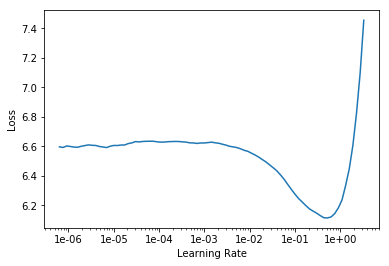

In [44]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(1, 5e-1, moms=(0.8,0.7))

Total time: 00:16
epoch  train_loss  valid_loss  accuracy
1      6.141987    5.349010    0.169107  (00:16)



In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 03:38
epoch  train_loss  valid_loss  accuracy
1      5.349348    5.093752    0.182016  (00:21)
2      5.114657    4.917808    0.200771  (00:21)
3      4.915718    4.781165    0.217949  (00:21)
4      4.738747    4.659684    0.233131  (00:21)
5      4.616238    4.570188    0.243775  (00:21)
6      4.483967    4.513829    0.251321  (00:22)
7      4.395194    4.478364    0.255191  (00:22)
8      4.310813    4.454600    0.259210  (00:21)
9      4.240767    4.447837    0.260974  (00:22)
10     4.229300    4.447820    0.260986  (00:22)



In [20]:
cbs = [EarlyStoppingCallback(learn)]

In [21]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7), callbacks=cbs)

epoch,train_loss,valid_loss,accuracy
1,4.240653,4.448188,0.260645
2,4.200986,4.430888,0.261817
3,4.183382,4.412378,0.265027
4,4.128592,4.398516,0.266269
5,4.020792,4.380794,0.267614
6,3.962836,4.375194,0.270689
7,3.892902,4.355853,0.275741
8,3.795051,4.335654,0.277305
9,3.703429,4.323894,0.279450
10,3.598668,4.323631,0.280704


Epoch 11: early stopping


In [46]:
learn.save('ft')

In [51]:
learn.save_encoder('ft_enc')

In [52]:
PATH.ls()

[PosixPath('/home/ck/data/azlyrics/prepared/train'),
 PosixPath('/home/ck/data/azlyrics/prepared/models'),
 PosixPath('/home/ck/data/azlyrics/prepared/lm'),
 PosixPath('/home/ck/data/azlyrics/prepared/valid'),
 PosixPath('/home/ck/data/azlyrics/prepared/songs.json')]

In [53]:
data_sup = (
    TextFileList
    .from_folder(PATH)
    .label_from_folder(classes=artists)
    .split_by_folder(valid='valid')
    .datasets()
    .tokenize()
    .numericalize(vocab = data_lm.vocab)
    .databunch(TextClasDataBunch, bs=50)
)

In [54]:
learn = text_classifier_learner(data_sup, drop_mult=0.5)
learn.load_encoder('ft_enc')

In [56]:
data_sup.show_batch()

text,label
"xxfld 1 father says it , mother says it \n sister says it , brother says it \n uncle says it , xxunk says it \n everyone at the party says \n babe , i 'm on fire \n babe , i 'm on fire \n\n the horse says it , the pig says it \n the judge in his wig says it \n the fox and the rabbit \n and the xxunk in her habit says \n babe , i 'm on fire \n babe , i 'm on fire \n\n my mate bill gates says it \n the",Nick Cave The Bad Seeds
"xxfld 1 [ intro : ] \n [ judge : ] "" alright , your xxunk with public xxunk , alright listen "" \n [ xxunk : ] "" there 's a thousand people out who 're drunk "" \n [ judge : ] "" okay , i understand that "" \n\n [ hook : j - ro ] \n we o - w in the whole zone \n the likwit crew is on the microphone \n let it rain brother [ 3x ] \n xzibit do your thing \n\n [ verse 1 : xzibit ] \n you get permanently",Xzibit
"xxfld 1 [ xzibit ] [ havoc in the background x8 : "" no doubt "" ] \n yea like this , rest in times , + infamous+ crew \n yea + infamous+ mobb deep , bring it down \n once again bring it live , yeah , like this \n\n i 'm on a path not thinkin bout a average man \n black xxunk my way through xxunk and xxunk \n let the whole world know about this likwit camp \n programmed to xxunk on site \n so now i 'm standin in a whole new light ( whole",Xzibit
xxfld 1 i live in a town called millhaven \n and it 's small and it 's mean and it 's cold \n but if you come around just as the sun goes down \n you can watch the whole town turn to gold \n it 's around about then that i used to go a - roaming \n singing la la la la la la la lie \n all god 's children they all got ta die \n my name is loretta but i xxunk xxunk \n i 'm closing in on my xxunk year \n and if you,Nick Cave The Bad Seeds
"xxfld 1 [ intro ] \n ahhh ! we bout to go this motherfuckin club tonight , y'knahmean ? \n poke some motherfuckin hoes , y'knahmean ? \n make sure them hoes , y'knahmean ? gon ' act xxunk , y'knahmean ? \n some nigga over there tryin to love one hoe \n y'knahmean ? you got one hoe ! \n nigga xxunk a stone motherfuckin jackson \n nigga xxunk a stony jackson , you ca n't fuck with us \n so nigga , tuck your tail and hide your hoe nigga \n\n [ jelly roll ] \n we parked",Xzibit
"xxfld 1 [ frida : ] i am frida . hello . \n i 'm the star of the show . \n [ agnetha : ] that 's what she thinks , anyway . \n [ frida : ] and i like to perform . \n benny says i am warm . \n [ benny : ] well hot is the least you can say . \n [ frida : ] xxunk and free , \n and xxunk , that 's me . \n and i 'm tough too , you see . \n [ benny : ] no she",ABBA
"xxfld 1 [ mike shinoda : ] \n i 'm standing in the middle of it , middle of it , middle of it \n\n yo , y' all better wake up , you think we do n't see y' all drifting ? \n sleeping on the job and forgetting your position ( position ) ? \n sit straight and listen what you are missing \n i cook up a xxunk , hot straight out the kitchen \n\n no xxunk , i spit right \n heavy as a fist fight \n no gloves and no masks \n no pain and",Linkin Park
"xxfld 1 [ intro : kurupt { xzibit } ] \n ' sup ? \n once in the lifetime ... ( haha ! ) \n kurupt young gotti ! ( you can place that ! ) { beat starts } \n xxup yeah ! \n it 's going down . ( xxup xxunk , xxup xxunk ! ) \n yeah ! \n x - to - the - z , xzibit ! { xxup yeah ! } \n ridin ' on ... { xxunk ! } \n xxup rough ! \n west , west ! ( yeah , yeah !",Xzibit
"xxfld 1 i was barely ten years old when i became the keeper \n of an atra virago , more xxunk known as the xxunk barking spider . \n but i had to let him go , for i could not xxunk . \n my atra virago was given to me by a hobo , in exchange for a xxunk of peel liquor , which i xxunk off one of ma 's xxunk the same evening . \n if i had been just a little stronger , i know i could have healed him . \n the exchange went as",Nick Cave The Bad Seeds
"xxfld 1 yeah ! xxup xxunk , xxup xxunk ! \n c'mon ! yeah , yeahhh ( yeah ) yeahhh , yeahhh \n m.o.p . ! uhh ( x to the z ) \n yeah baby , that 's righ

In [57]:
learn.freeze()

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


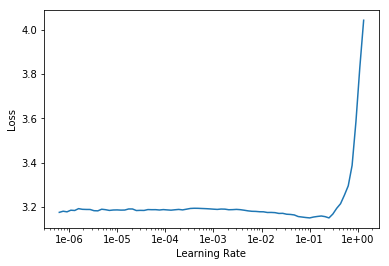

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(1, 1e-02, moms=(.8, .7))

Total time: 00:17
epoch  train_loss  valid_loss  accuracy
1      3.107980    3.085465    0.071633  (00:17)



In [61]:
learn.fit_one_cycle(3, 1e-02, moms=(.8, .7))

Total time: 00:53
epoch  train_loss  valid_loss  accuracy
1      3.068977    3.383687    0.038682  (00:18)
2      3.070299    3.109347    0.051576  (00:16)
3      3.060627    3.105102    0.051576  (00:18)



In [62]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      3.027663    3.097754    0.074499  (00:19)



In [63]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 00:30
epoch  train_loss  valid_loss  accuracy
1      2.945971    2.892573    0.151862  (00:30)



In [64]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy


RuntimeError: CUDA error: out of memory